# Audio Data Classification with Xt-Training
## Notebook Purpose

This notebook is an example of how to use xt-training for time series classification. In addition, it will demonstrate how to use xt-training with scikit-learn models using `SKDataset` and `SKInterface`.

## Approach

- We will use the [Free Spoken Digit Dataset](https://github.com/Jakobovski/free-spoken-digit-dataset). This is a spoken word dataset that consists of recordings of 6 speakers saying digits 0-9. It is basically MNIST for audio data.
- First, we will extract features from the audio signal using librosa
- Then, we will use the extracted features to train an XGBoost model for sklearn

## Data exploration

First, let's import all the modules we will need and explore the data a bit.

In [1]:
import numpy as np
from random import randint
import glob, os

import torch
from torch import nn
from torch.utils.data import DataLoader, random_split, Subset
from torchvision import transforms
import librosa
import librosa.display
from xgboost import XGBClassifier
from sklearn.inspection import permutation_importance

from xt_training import metrics
from xt_training.utils import DummyOptimizer, SKDataset, SKInterface, functional

from IPython.display import Audio
from IPython.core.display import display

In [2]:
# function to play an audio sample from a numpy array
def play_audio(sample, sr):
    display(Audio(sample, rate=sr))

In [3]:
# you will need to clone the FSDD repository (linked above)
# then, replace this with the path to the recordings directory
dataset_path = '/path/to/free-spoken-digit-dataset/recordings/'
fps = glob.glob("{}/*.wav".format(dataset_path))
print(len(fps))

3000


<class 'numpy.ndarray'>
sr = 22050


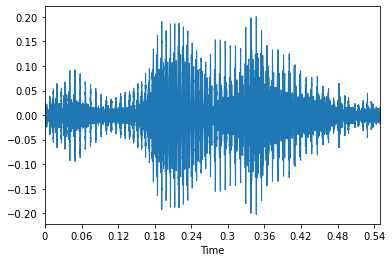

In [4]:
fp = fps[randint(0,len(fps)-1)]
x, sr = librosa.load(fp)
print(type(x))
print("sr = {}".format(sr))
librosa.display.waveplot(x, sr)
play_audio(x, sr)

So, we can see that our dataset consists of 3000 samples and that each sample is an audio clip between 0 and 1 seconds long.

## Dataset class and transforms

Now we can define a dataset wrapper class for the FSD Dataset. We have several requirements for this class:
1. This is a regular PyTorch dataset, so we will need to define `__init__`, `__getitem__`, and `__len__` functions. More info on PyTorch datasets [here](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html). 
2. We need to extract the class id from the filepath and use librosa to load the waveform
3. We should also apply any transforms that we have passed in. We will use the transforms to extract features from the waveform while training.

In [5]:
class FSDDataset:
    def __init__(self, root, transform=None):
        self.root = root
        self.transform = transform
        self.filenames = os.listdir(self.root)
        
    def __getitem__(self, index):
        fp = os.path.join(self.root, self.filenames[index])
        x, sr = librosa.load(fp)
        # apply the transforms
        name, ext = os.path.splitext(self.filenames[index])
        label, speaker, index = name.split('_')
        if self.transform is not None:
            x = self.transform(x)
        return x.astype(np.float32), int(label)
    
    def __len__(self):
        return len(self.filenames)

For our transforms, we want to extract various features from the waveform and then we want to concatenate these all together into a single, flat list. We can use these lists of features to train an XGBoost model.

Torchvision's `transforms.Compose` provides an easy way to chain together sequential transform functions. But, we want to apply all of our transform functions to the original waveform in parallel, so we must define a new transform wrapper class. This class should also keep track of the sampling rate (sr) since many transform functions depend on it.

In [6]:
class TransformWrapper:
    def __init__(self, transforms=None, sr=22050, axis=0):
        self.axis = axis
        self.sr = sr
        self.transforms = transforms

    def __call__(self, x_in):
        if self.transforms is None:
            return np.concatenate(x_in, axis=self.axis)
        return np.concatenate([t(x_in, self.sr) for t in self.transforms], axis=self.axis)

## Feature selection

Librosa's `feature` module provides many great functions for audio signal processing feature extraction. Documentation for librosa.feature can be found [here](https://librosa.org/doc/main/feature.html).

Finding good features often involves a lot of trial and error. Luckily, sklearn provides us with an easy way to measure feature importance. For audio signals that are based upon human hearing (ie music data, spoken word, etc.), Mel Frequency Cepstrum Coefficients (MFCC) are often the some of the best features. Starting with these is probably a good idea in our case. The other features were found by iteratively trying new features, training an XGBoost model, measuring the feature importance, and then adjusting the features and starting over again.

Note that we keep track of the names of the features so that we can more easily evaluate feature importance.

In [7]:
# a list of all our feature transforms
transform_list = [
    lambda x, sr: np.mean(librosa.feature.mfcc(x, n_mfcc=20), axis=1),
    lambda x, sr: np.std(librosa.feature.mfcc(x, n_mfcc=20), axis=1),
    lambda x, sr: np.mean(librosa.feature.chroma_stft(x, sr=sr, n_chroma=12), axis=1),
    lambda x, sr: np.std(librosa.feature.chroma_stft(x, sr=sr, n_chroma=12), axis=1),
    lambda x, sr: np.mean(librosa.feature.zero_crossing_rate(x), axis=1),
    lambda x, sr: np.std(librosa.feature.zero_crossing_rate(x), axis=1),
]
# a nested list of the names of our features. We will use this later for tracking feature importance
transform_names = [
    ['mfcc_avg_{}'.format(i) for i in range(20)],
    ['mfcc_std_{}'.format(i) for i in range(20)],
    ['chroma_stft_avg_{}'.format(i) for i in range(12)],
    ['chroma_stft_std_{}'.format(i) for i in range(12)],
    ['zcr_avg', 'zcr_std'],
]
# flatten the names
transform_names = [item for sublist in transform_names for item in sublist]

train_transforms = transforms.Compose([
    # any preprocessing transforms can go here (noise reduction, trimming, etc.)
    TransformWrapper(transforms=transform_list),
    # any postprocessing transforms can go here (changing the shape or datatype, etc.)
])

# there are no random augmentations, so our inference transforms can be the same as for training
val_transforms = train_transforms
test_transforms = train_transforms

## Training the model

Now that we have a dataset class and our transforms out of the way, we can start training a model. First though, let's load up our datasets and transforms and ensure that they are all the proper format.

In [8]:
dataset = FSDDataset(
    root=dataset_path,
    transform=train_transforms,
)

In [9]:
print("number of features = {}".format(len(transform_names)))
x, y = dataset[randint(0,len(dataset)-1)]
print("x type = {}, {}".format(type(x), x.dtype))
print("x shape = {}".format(x.shape))
print("label type = {}".format(type(y)))
print("label = {}".format(y))

number of features = 66
x type = <class 'numpy.ndarray'>, float32
x shape = (66,)
label type = <class 'int'>
label = 1


Our number of features matches the shape of the data sample and our label is an int between 0-9. So, looks like our dataset and transforms are working as intended.

Now, let's split our dataset into train, val and test sets. Also, we should wrap our datasets in the `SKDataset` wrapper as this allows xt-training to work properly with sklearn models.

In [10]:
train_dataset, val_dataset, test_dataset = random_split(
    dataset,
    [int(len(dataset)*0.7), int(len(dataset)*0.1), int(len(dataset)*0.2)]
)

train_dataset = SKDataset(train_dataset)
val_dataset =   SKDataset(val_dataset)
test_dataset = SKDataset(test_dataset)

`SKDataset` makes one major change: it returns the sample and the label as a single tuple (x,y), but also returns the label alone. This is because the `fit` method of sklearn models expects both x and y together, but pytorch handles the input sample and the label separately, in the `forward` method and loss function, respectively. Let's double check that this is all working as intended. 

In [11]:
# y1 and y2 should be equal
(x, y1), y2 = train_dataset[randint(0,len(train_dataset)-1)]
print("x type = {}, {}".format(type(x), x.dtype))
print("x shape = {}".format(x.shape))
print("y1 type = {}".format(type(y1)))
print("y1 = {}".format(y1))
print("y2 type = {}".format(type(y2)))
print("y2 = {}".format(y2))

x type = <class 'numpy.ndarray'>, float32
x shape = (66,)
y1 type = <class 'int'>
y1 = 1
y2 type = <class 'int'>
y2 = 1


Okay, looks like that is good.

Now we load all the datasets into data loaders so that we can use them with xt-training's functional API. Note that our batch size is a number that is greater than our dataset size. This is intended, because it will force the dataloader to give the sklearn model all the data at the same time, which is what it expects.

In [12]:
# Everything is dumped in a single batch with sklearn
batch_size = 1000000

num_workers = 4

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    shuffle=True,
)
val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    shuffle=True,
)
test_loaders = {
    'test': DataLoader(
        test_dataset,
        batch_size=batch_size,
        num_workers=num_workers,
        shuffle=True,
    )
}

Here we define the last few things before we can begin training.

The sklearn model is passed into `SKInterface` as `base_model`. This wrapper supports any [sklearn model](https://scikit-learn.org/stable/supervised_learning.html) or any model that was implemented with the sklearn api, like [this XGBoost model](https://xgboost.readthedocs.io/en/latest/python/python_api.html#module-xgboost.sklearn).

Note that the optimizer, loss_fn, and epochs don't really do anything since the sklearn model will handle loss, optimization, and any iterative training. We still need to define them as placeholders, however.

For more information about the eval metrics, see this [image classification example](https://xt-training.readthedocs.io/en/latest/Image-Classification/).

In [13]:
model = SKInterface(
    base_model=XGBClassifier(
        objective='multi:softprob',
        n_estimators=700,
        learning_rate=0.025,
        use_label_encoder=False,
        num_class=10,
        eval_metric='mlogloss',
        max_depth=4,
    ),
    output_dim=10
)

optimizer = DummyOptimizer()
loss_fn = nn.NLLLoss() # Use this rather than cross-entropy for SKWrapper models
epochs = 1

eval_metrics = {
    'acc': metrics.Accuracy(),
    'eps': metrics.EPS(),
    'y_mean': lambda _, y: y.float().mean(),
    'n': lambda _, y: torch.as_tensor(y.shape[0]).float(),
}

Finally, we can begin training. We simply pass in all the things we've defined previously and xt-training will report metrics as it trains.

In [14]:
save_dir = 'checkpoints/fsdd_example'

result = functional.train(
    save_dir=save_dir,
    train_loader=train_loader,
    model=model,
    optimizer=optimizer,
    epochs=epochs,
    loss_fn=loss_fn,
    overwrite=True,
    val_loader=val_loader,
    test_loaders=test_loaders,
    eval_metrics=eval_metrics,
    on_exit=functional.train_exit
)

Running on device: cuda:0


Initial
----------
test     |     1/1    | loss:    0.9631 | acc:    0.1150 | eps:   59.6087 | y_mean:    4.4583 | n:  600.0000   
valid    |     1/1    | loss:    1.0138 | acc:    0.0900 | eps:   67.5916 | y_mean:    4.4500 | n:  300.0000   

Epoch 1/1
----------
train    |     1/1    | loss:    0.0062 | acc:    1.0000 | eps:   51.6247 | y_mean:    4.5190 | n: 2100.0000   
valid    |     1/1    | loss:    0.1462 | acc:    0.9567 | eps:   66.5715 | y_mean:    4.4500 | n:  300.0000   
Saved new best: 0.1462

Test
----------
test     |     1/1    | loss:    0.1304 | acc:    0.9650 | eps:   67.9045 | y_mean:    4.4583 | n:  600.0000   


## Improving the model

If we are not satisfied with the performance of our model, we should remove un-important features and try out new features. Sklearn provides a function `permutation_importance` that will measure how important each feature is. Using this, we can rank our features and only keep the features that help with performance.

In [15]:
X_val = [x for (x, _), y in val_dataset]
y_val = [y for (x, _), y in val_dataset]

r = permutation_importance(
    model.base_model,
    X_val,
    y_val,
    n_repeats=30,
    random_state=0,
)

for i in r.importances_mean.argsort()[::-1]:
    print(f"{transform_names[i]:<24} \t"
        f"{r.importances_mean[i]:.3f}"
        f" +/- {r.importances_std[i]:.3f}")

mfcc_avg_4               	0.171 +/- 0.019
mfcc_avg_3               	0.111 +/- 0.013
zcr_avg                  	0.069 +/- 0.012
mfcc_avg_5               	0.041 +/- 0.008
mfcc_std_3               	0.038 +/- 0.009
mfcc_avg_16              	0.028 +/- 0.010
mfcc_std_4               	0.024 +/- 0.009
zcr_std                  	0.015 +/- 0.004
mfcc_std_9               	0.014 +/- 0.004
mfcc_std_7               	0.012 +/- 0.005
mfcc_avg_10              	0.012 +/- 0.004
mfcc_std_2               	0.011 +/- 0.005
mfcc_avg_18              	0.010 +/- 0.004
mfcc_avg_14              	0.010 +/- 0.004
mfcc_std_5               	0.007 +/- 0.004
mfcc_std_0               	0.007 +/- 0.002
mfcc_avg_17              	0.006 +/- 0.002
mfcc_avg_7               	0.006 +/- 0.003
mfcc_avg_6               	0.006 +/- 0.003
mfcc_avg_2               	0.006 +/- 0.005
mfcc_avg_0               	0.005 +/- 0.003
mfcc_std_1               	0.005 +/- 0.002
mfcc_std_11              	0.005 +/- 0.002
mfcc_avg_13              	0.004 +/